In [2]:
import numpy as np 
import pandas as pd
from IPython.display import display 
import matplotlib.pyplot as plt
%matplotlib inline
data=pd.read_csv('train.csv')    

In [3]:
display(data.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
                                    ##### DATA PREPROCESSING #####
# Check if columns have NA entries #####
count=dict() # Keys are feature names, and items are missing entries counts.
def missing_entries(data):
    for ii in data.columns:
     count[ii]=np.sum(data[ii].isnull())
     miss_entr=np.sum(data[ii].isnull())
     print('The feature {} has {} missing entries.'.format(ii,miss_entr))
    return count


In [5]:
count=missing_entries(data)
    

The feature PassengerId has 0 missing entries.
The feature Survived has 0 missing entries.
The feature Pclass has 0 missing entries.
The feature Name has 0 missing entries.
The feature Sex has 0 missing entries.
The feature Age has 177 missing entries.
The feature SibSp has 0 missing entries.
The feature Parch has 0 missing entries.
The feature Ticket has 0 missing entries.
The feature Fare has 0 missing entries.
The feature Cabin has 687 missing entries.
The feature Embarked has 2 missing entries.


In [6]:
######## Extracting designation of each passenger #####
def extract_desig(input_data):
    import re
    designation=list()
    for ii in (input_data['Name']):
        t=re.findall(r",(.*)\.",ii)[0]
        designation.append(t)
    
    designation=pd.DataFrame(designation,columns=['Designation'])  
    df1=input_data.copy()
    df1=df1.drop(['Name','Ticket','Cabin','PassengerId'],axis=1)
    df1=pd.concat([df1,designation],axis=1)
    df1.head()
    return df1

In [7]:
############# Replacing missing Ages with it's corrosponding designation's mean
def Age_meanimpute(df2):
    
    Age_ind=df2['Age'].isnull()
    df=df2.copy()
    temp=pd.DataFrame(df2.groupby(['Designation'])['Age'].mean())
    df=df[Age_ind]
    for ii in df.index.tolist(): 
        for jj in temp.index.tolist(): 
            if df.loc[ii,'Designation']==jj: 
                df.loc[ii,'Age']=temp.loc[jj,'Age']
    df2[Age_ind]=df
    return(df2)    

In [8]:
###### Replacing the 2 Embarked NAN positions with most frequently embarked port S
def Embark_impute(df3):
    df3['Embarked'].describe()
    Emb_ind=df3['Embarked'].isnull()
    df3.loc[Emb_ind,'Embarked']='S'
    return df3

In [9]:
########### Designation into 5 different buckets #########
'''
There are a total of 19 designations, we divide them into 5 buckets based on the age range 
plot 'plt.hist(data_cpy.groupby(['Designation'])['Age'].mean(),bins=5)'

'''
def desig_bin_divide(df4):


    def desig_bucket(df2,input_arr): 
        desig_ind=df['Designation'].isin(input_arr)
        df2.loc[desig_ind,'Designation']=input_arr[0]
        #print(input_arr[0])
        return df2
    df=df4.copy()

    arr=dict()
    arr={0:[' Master'],
         1:[' Ms',' Mr',' Mme',' Mlle',' Miss'],
         2:[' Don',' Dr',' Jonkheer',' Rev',' the Countess',' Mrs'],
         3:[' Lady',' Major',' Mrs. Martin (Elizabeth L',' Sir'],
         4:[' Col',' Capt']
         }
    for ii in arr.keys():
        df4=desig_bucket(df4,arr[ii])
    df4['Designation'].unique() 
    return df4

In [10]:
data_cpy=extract_desig(data)
Age_groupedby_desig=pd.DataFrame(data_cpy.groupby(['Designation'])['Age'].mean())
data_cpy=Age_meanimpute(data_cpy)
data_cpy=Embark_impute(data_cpy)
data_cpy=desig_bin_divide(data_cpy)

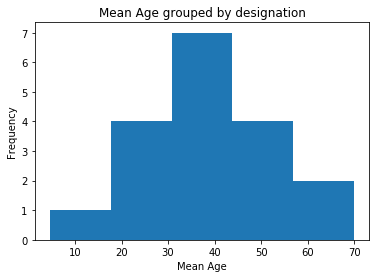

In [11]:
'''
We are converting designation feature with 18 entries to a categorical variable of 5 entries based on the age feature. 
A dependency can be assumed between Designation and Age features. 
Designation buckets w.r.t Age are given in desig_bin_divide function.
'''
plt.hist(Age_groupedby_desig['Age'],bins=5)
plt.xlabel('Mean Age')
plt.title('Mean Age grouped by designation')
plt.ylabel('Frequency')
plt.show()

In [12]:
#### Function for splitting data, log transforming skewed features, normalizing features with extreme values
def split_data(df1,output_var,frac,norm_feat,log_feat):
    target=df1[output_var]
    df1=df1.drop(output_var,axis=1)
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test=train_test_split(df1,target,test_size=frac,random_state=0)
    from sklearn.preprocessing import MinMaxScaler 
    scaler=MinMaxScaler()
    ##### Log transform of train and test data. Apply log transform to skewed data
    df1[log_feat]=df1[log_feat].apply(lambda x:np.log(x + 1))
    X_train[log_feat]=X_train[log_feat].apply(lambda x:np.log(x + 1)) 
    X_test[log_feat]=X_test[log_feat].apply(lambda x:np.log(x + 1))
    ##### Normalization of train and test data
    df1[norm_feat]=scaler.fit_transform(df1[norm_feat])
    X_train[norm_feat]=scaler.fit_transform(X_train[norm_feat])
    X_test[norm_feat]=scaler.fit_transform(X_test[norm_feat])

    return df1,X_train,X_test,y_train,y_test
    

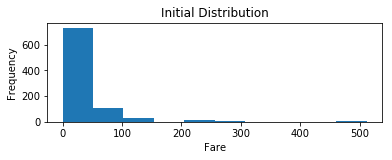

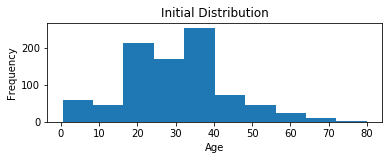

In [13]:
'''
Some continous features could have skewed values, i.e., some of their entries could be completely in the extremes
'''
plt.figure(1)
plt.subplot(211)
plt.hist(data_cpy['Fare'])
plt.xlabel('Fare')
plt.ylabel('Frequency')
plt.title('Initial Distribution')
plt.figure(2)
plt.subplot(212)
plt.hist(data_cpy['Age'])
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Initial Distribution')
plt.show()

In [14]:
pd.options.mode.chained_assignment = None   #### Command for removing any warning for chaining operations
data_cpy=pd.get_dummies(data_cpy)
data_cpy.head()
feature_tobe_normalized=['Fare','Age']
feature_tobe_log=['Fare']
final_data_cpy,features_train,features_test,out_train,out_test=split_data(data_cpy,'Survived',0.2,
                                                feature_tobe_normalized,feature_tobe_log)

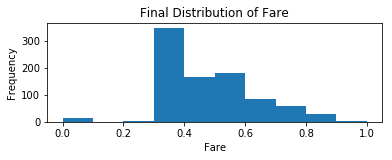

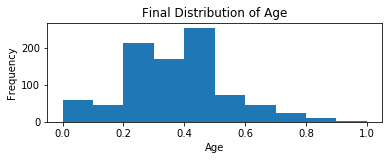

In [15]:
'''
Log, norm transformations of Fare feature and norm transformation of Age feature

'''
plt.figure(1)
plt.subplot(211)
plt.hist(final_data_cpy['Fare'])
plt.xlabel('Fare')
plt.ylabel('Frequency')
plt.title('Final Distribution of Fare')
plt.figure(2)
plt.subplot(212)
plt.hist(final_data_cpy['Age'])
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Final Distribution of Age')
plt.show()

In [16]:
'''
To get an understanding of any classifier, it is good to calculate the naive predictor performance, 
where in predicted values for a person is always 1, i.e., no training is present!
'''
naive_pred=np.ones(len(out_train))
from sklearn.metrics import accuracy_score, fbeta_score,make_scorer
print('Naive predictor accuracy is {:.2f}% and f_beta score is {:.2f}.'
                                                                .format(accuracy_score(out_train,naive_pred)*100,
                                                                fbeta_score(out_train,naive_pred,beta=0.5)))
    



Naive predictor accuracy is 38.34% and f_beta score is 0.44.


In [17]:
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_validate

clf_A=linear_model.LogisticRegression(random_state=0)
clf_B=RandomForestClassifier(random_state=0)
clf_C=SVC(random_state=0)
clf_D = AdaBoostClassifier(random_state=0)

for clf in [clf_A,clf_B,clf_C,clf_D]:
    clf_name = clf.__class__.__name__
    acc_scorer=make_scorer(accuracy_score)
    acc_scores = cross_validate(clf, features_train, out_train, scoring=acc_scorer,
                        cv=5, return_train_score=True)
    f_scorer=make_scorer(fbeta_score,beta=0.5)
    fbeta_scores = cross_validate(clf, features_train, out_train, scoring=f_scorer,
                        cv=5, return_train_score=True)
    print('For classifier:{}, CV_accuracy:{:.9f}, f_beta:{:.2f}'.format(clf_name,
                                                                np.mean(acc_scores['test_score']),
                                                                np.mean(fbeta_scores['test_score'])
                                                                ))


For classifier:LogisticRegression, CV_accuracy:0.834361852, f_beta:0.80
For classifier:RandomForestClassifier, CV_accuracy:0.800627142, f_beta:0.75
For classifier:SVC, CV_accuracy:0.831574639, f_beta:0.79
For classifier:AdaBoostClassifier, CV_accuracy:0.810506694, f_beta:0.76


In [18]:
######### Using SVC  as the final optimizer #########
def train_pred(input_features,output_features):
    from sklearn import grid_search 
    from sklearn.metrics import accuracy_score
    from sklearn.svm import SVC
    clf=SVC(random_state=6)
    parameters={'kernel':['linear','rbf'],
                'C':[1e-2, 1, 1e2],
                'gamma':[1e-1, 1, 1e1]
               }
    scorer=make_scorer(accuracy_score)
    grid_obj=grid_search.GridSearchCV(estimator=clf,param_grid=parameters,scoring=scorer)
    
    grid_fit=grid_obj.fit(input_features,output_features)
    best_clf = grid_fit.best_estimator_
    
    return clf,best_clf

    ##### Comparing unoptimized model to optimzied model 
clf_train,best_clf_train=train_pred(features_train,out_train)
unoptimized_pred=clf_train.fit(features_train,out_train).predict(features_test)
optimized_pred=best_clf_train.predict(features_test)

print('accuracy score for unoptimized model:{:.8f}'.format(accuracy_score(out_test,
                                                                          unoptimized_pred)))
print('accuracy score for optimized model:{:.8f}'.format(accuracy_score(out_test,
                                                                        optimized_pred)))
    

/Users/ashvinsrinivasan/Library/Enthought/Canopy/edm/envs/User/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/ashvinsrinivasan/Library/Enthought/Canopy/edm/envs/User/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


accuracy score for unoptimized model:0.82681564
accuracy score for optimized model:0.82681564


In [19]:
########### Importing actual test data #########
test_data=pd.read_csv('test.csv') 
test_data.head()
passenger_id=test_data['PassengerId']

In [20]:
test_df=extract_desig(test_data)
test_df=Age_meanimpute(test_df)
test_df=Embark_impute(test_df)
test_df=desig_bin_divide(test_df)
'''
two observations in the test test have NAN's imputed manually
'''
test_df.loc[test_df['Fare'].isnull(),'Fare']=np.min(test_df['Fare'])
test_df.loc[test_df['Age'].isnull(),'Age']=28.0
from sklearn.preprocessing import MinMaxScaler 
scaler=MinMaxScaler()
norm_feats=['Fare','Age']
log_feats=['Fare']
##### Log transform of train and test data
test_df[log_feats]=test_df[log_feats].apply(lambda x:np.log(x + 1)) # Apply log transform to skewed data, show it is skewed
##### Normalization of train and test data
test_df[norm_feats]=scaler.fit_transform(test_df[norm_feats])

test_df=pd.get_dummies(test_df) 
#### Training over the entire data set
final_feat_train=final_data_cpy
final_out_train=data_cpy['Survived']

In [21]:
test_pred=best_clf_train.fit(final_feat_train,final_out_train).predict(test_df)

In [22]:
best_clf_train

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=6, shrinking=True,
  tol=0.001, verbose=False)

In [23]:
final_df=pd.DataFrame(pd.concat([passenger_id,pd.Series(test_pred)],axis=1))
final_df.to_csv('final_submission.csv', sep=',', encoding='utf-8')

In [24]:
'''
The final survival rate accuracy on the unseen test data from Kaggle is 79.425% using the above feature transformations,
model selection and model optimization using hyper parameters.
'''

'\nThe final survival rate accuracy on the unseen test data from Kaggle is 79.425% using the above feature transformations,\nmodel selection and model optimization using hyper parameters.\n'